In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import matplotlib as mpl

mpl.rcParams["figure.dpi"] = 1000
# mpl.rcParams['legend.fontsize'] = 15
# params = {'legend.fontsize': 20,
#           'legend.handlelength': 2}
# plot.rcParams.update(params)

In [4]:
from algorithms.moo.nsga2 import NSGA2
from constraints.as_obj import ConstraintsAsObjective
from operators.survival.rank_and_crowding.classes import (
    RankAndCrowding,
    MyConstrRankAndCrowding,
    ParallelConstrRankAndCrowding,
    MyConstrRankAndCrowding2,
)
from optimize import minimize
from visualization.scatter import Scatter
from pymoo.problems import get_problem

In [5]:
from algorithms.moo.nsga2 import binary_tournament, constr_binary_tournament
from operators.selection.tournament import TournamentSelection


core_moea1 = NSGA2(pop_size=300, survival=RankAndCrowding(crowding_func="2nn"),
                   eliminate_duplicates=True)
core_moea2 = NSGA2(
    pop_size=300, selection=TournamentSelection(func_comp=constr_binary_tournament), survival=MyConstrRankAndCrowding(crowding_func="2nn"), eliminate_duplicates=True)
core_moea3 = NSGA2(
    pop_size=300, survival=ParallelConstrRankAndCrowding(crowding_func="2nn"), eliminate_duplicates=True)
core_moea4 = NSGA2(
    pop_size=300, survival=MyConstrRankAndCrowding2(crowding_func="2nn"), eliminate_duplicates=True)

In [6]:
import time


def performance_timer(func):
    """
    A decorator to measure and print the execution time of a function.
    """

    def wrapper(*args, **kwargs):
        start_time = time.time()  # Capture the start time
        result = func(*args, **kwargs)  # Execute the function
        end_time = time.time()  # Capture the end time
        duration = end_time - start_time  # Calculate duration
        # print(f"{func.__name__} executed in {duration:.6f} seconds")
        return result

    return wrapper


@performance_timer
def minimize_(*args, **kwargs):
    return minimize(*args, **kwargs)

In [7]:
from pymoo.indicators.gd import GD
from pymoo.indicators.gd_plus import GDPlus
from pymoo.indicators.igd import IGD
from pymoo.indicators.igd_plus import IGDPlus
from pymoo.indicators.hv import HV

metric_classes = {
    "Generational Distance (GD)": GD,
    "Generational Distance Plus (GD+)": GDPlus,
    "Inverted Generational Distance (IGD)": IGD,
    "Inverted Generational Distance Plus (IGD+)": IGDPlus,
    # "Hypervolume": HV,
}


def performance_indicators(pf, results):
    # Pre-configuration for each metric, handle special cases like HV here.
    pf_calculators = [
        (
            metric_class(ref_point=np.array([0, 0]))
            if metric_name == "Hypervolume"
            else metric_class(pf)
        )
        for metric_name, metric_class in metric_classes.items()
    ]

    def cal_acc_metric(sols):
        results_matrix = np.empty(
            (len(sols), len(metric_classes)), dtype=object)

        for idx, sol in enumerate(sols):
            # Ensure `sol` is a 2D array with the correct shape [n_samples, n_features]
            sol = np.atleast_2d(sol)
            if sol.shape[0] == 1 and sol.shape[1] != len(pf):
                # This implies sol is a single sample with multiple features, which is the correct format
                pass
            elif sol.shape[1] == 1 and sol.shape[0] != len(pf):
                # This implies sol has the wrong orientation; it's many samples of a single feature
                sol = sol.T

            for metric_idx, calculator in enumerate(pf_calculators):
                try:
                    results_matrix[idx, metric_idx] = calculator(sol)
                except Exception as e:
                    # print(
                    #     f"Error calculating {list(metric_classes.keys())[metric_idx]}: {e}")
                    results_matrix[idx, metric_idx] = np.nan

        return [
            (np.mean(results_matrix[:, i]), np.median(results_matrix[:, i]))
            for i in range(len(pf_calculators))
        ]

    return [cal_acc_metric(rs) for rs in results]

In [8]:
from constraints.as_obj import CVRAsObjective, CDFAsObjective, CVRAsObjective2, CDFAsObjective2


@performance_timer
def compare_on(problem, n_gen=300):
    # Configuration for each optimization strategy
    configurations = [
        # (problem, core_moea1, ("n_gen", n_gen), {"seed": 1, "verbose": False}),
        (ConstraintsAsObjective(problem),
         core_moea1, ("n_gen", n_gen), {"seed": 1}),
        (CVRAsObjective(problem),
         core_moea1, ("n_gen", n_gen), {"seed": 1}),
        (CDFAsObjective(problem),
         core_moea1, ("n_gen", n_gen), {"seed": 1}),
        (
            CVRAsObjective2(problem),
            core_moea1,
            ("n_gen", n_gen),
            {"seed": 1, "verbose": False},
        ),
        (
            CDFAsObjective2(problem),
            core_moea1,
            ("n_gen", n_gen),
            {"seed": 1, "verbose": False},
        ),
        # (ConstraintsAsObjective(problem),
        #  core_moea2, ("n_gen", n_gen), {"seed": 1}),
        # (
        #     CVRAsObjective(problem),
        #     core_moea2,
        #     ("n_gen", n_gen),
        #     {"seed": 1, "verbose": False},
        # ),
        # (
        #     CVRAsObjective2(problem),
        #     core_moea4,
        #     ("n_gen", n_gen),
        #     {"seed": 1, "verbose": False},
        # ),
        # (
        #     CDFAsObjective(problem),
        #     core_moea2,
        #     ("n_gen", n_gen),
        #     {"seed": 1, "verbose": False},
        # ),
        # (
        #     CDFAsObjective2(problem),
        #     core_moea4,
        #     ("n_gen", n_gen),
        #     {"seed": 1, "verbose": False},
        # ),
    ]

    results = []
    for config in configurations:
        result = minimize_(*config[:-1], **config[-1])
        results.append(result)
    return results


def test(problem_name, n_gen=300, *args):
    if "dascmop" in problem_name:
        problem = get_problem(problem_name, args[0])
    elif "modact" in problem_name:
        problem = get_problem(problem_name, args[0])
    else:
        problem = get_problem(problem_name)
    pf = problem.pareto_front()
    # print(
    #     f"Problem {problem.name}: n_var={problem.n_var} n_obj={problem.n_obj} n_ieq_constr={problem.n_ieq_constr} n_eq_constr={problem.n_eq_constr}"
    # )

    results = compare_on(problem, n_gen=n_gen)

    # Check if any of the results is None
    if any(result is None for result in results):
        print("One or more optimization runs failed to return a result.")
        # Return None in place of results to indicate failure
        return pf, [None] * len(results)

    # Prepare data for performance indicators, safely handling cases where result.F might be None or incorrectly shaped
    prepared_data = []
    for i, result in enumerate(results):
        if result and hasattr(result, "F") and result.F is not None:
            # i == 0 this NGSA without additional objective
            if i in [0, 1, 2]:
                # if i == 1 or i == 3:
                # if True:
                prepared_data.append(result.F[:, :-1])
            else:
                # prepared_data.append(result.F[:, :-1])
                prepared_data.append(result.F[:, :-2])
        else:
            # Use None or an appropriate placeholder if result is invalid
            print(f'algo {i} not converge')
            prepared_data.append(None)

    # Ensure all data is valid before calculating performance indicators
    if all(data is not None for data in prepared_data):
        performance_results = performance_indicators(pf, prepared_data)
        for i, metric in enumerate(metric_classes.keys()):
            pass
            # print(
            #     f"{metric}: " +
            #     " | ".join(f"{perf[i]}" for perf in performance_results)
            # )
    else:
        print("Performance indicators could not be calculated due to invalid data.")

    return pf, *results

# BNH


In [19]:
for i in range(1, 100, 10):
    # print(f"\n I = {i}")
    pf, *results = test("bnh", n_gen=i)
    print(len(results[0].F[results[0].F[:, -1] == 0]),
          len(results[1].F[results[1].F[:, -1] == 0]),
          len(results[2].F[results[2].F[:, -1] == 0]),
          len(results[3].F[results[3].F[:, -2] == 0]),
          len(results[4].F[results[4].F[:, -2] == 0])
          )

70 70 70 70 70
300 300 300 300 300
300 300 300 300 300
300 300 300 300 300
300 300 296 299 299
300 300 300 299 299
300 300 300 300 300
300 300 300 300 300
300 300 300 300 300
300 299 300 300 300


In [8]:
for i in range(1, 100, 10):
    # print(f"\n I = {i}")
    pf, *results = test("carside", n_gen=i)
    print(len(results[0].F[results[0].F[:, -1] == 0]),
          len(results[1].F[results[1].F[:, -1] == 0]),
          len(results[2].F[results[2].F[:, -1] == 0]),
          len(results[3].F[results[3].F[:, -2] == 0]),
          len(results[4].F[results[4].F[:, -2] == 0])
          )

24 24 24 24 24
56 116 105 72 64
65 110 108 69 58
71 123 112 73 69
68 123 107 80 65
66 124 104 71 72
68 124 106 58 65
63 112 101 56 67
63 111 111 63 52
58 121 113 64 56


In [15]:
for i in range(1, 100, 10):
    # print(f"\n I = {i}")
    pf, *results = test("tnk", n_gen=i)
    print(len(results[0].F[results[0].F[:, -1] == 0]),
          len(results[1].F[results[1].F[:, -1] == 0]),
          len(results[2].F[results[2].F[:, -1] == 0]),
          len(results[3].F[results[3].F[:, -2] == 0]),
          len(results[4].F[results[4].F[:, -2] == 0])
          )

6 6 6 6 6
10 38 32 15 9
9 78 58 13 7
8 107 78 12 7
6 132 91 7 9
7 150 113 12 7
12 176 133 12 11
7 186 149 9 5
9 201 158 8 10
10 211 175 3 10


In [17]:
for i in range(1, 100, 10):
    # print(f"\n I = {i}")
    pf, *results = test("osy", n_gen=i)
    print(len(results[0].F[results[0].F[:, -1] == 0]),
          len(results[1].F[results[1].F[:, -1] == 0]),
          len(results[2].F[results[2].F[:, -1] == 0]),
          len(results[3].F[results[3].F[:, -2] == 0]),
          len(results[4].F[results[4].F[:, -2] == 0])
          )

1 1 1 1 1
10 10 8 11 3
4 9 10 7 4
4 6 6 7 6
5 6 2 4 4
2 5 3 4 3
3 6 7 3 4
1 7 3 2 7
3 5 5 3 5
2 7 3 2 2


In [10]:
for j in range(1, 10):
    print(f"\nDASCMOP{j}-1")
    for i in range(1, 350, 50):
        # print(f"\n I = {i}")
        pf, *results = test(f"dascmop{j}", i, 1)
        print(len(results[0].F[results[0].F[:, -1] == 0]),
            len(results[1].F[results[1].F[:, -1] == 0]),
            len(results[2].F[results[2].F[:, -1] == 0]),
            len(results[3].F[results[3].F[:, -2] == 0]),
            len(results[4].F[results[4].F[:, -2] == 0])
            )


DASCMOP1-1
2 2 2 2 2
6 9 17 16 16
47 49 62 64 64
90 90 130 121 121
113 130 175 174 174
155 183 231 204 204
189 215 252 247 247

DASCMOP2-1
2 2 2 2 2
12 9 8 9 9
49 60 41 38 38
98 106 82 100 100
129 165 124 152 152
166 218 195 220 220
222 245 235 231 231

DASCMOP3-1
3 3 3 3 3
5 3 4 11 11
7 55 13 84 84
8 110 17 179 179
13 203 20 216 216
15 217 36 199 199
21 208 31 162 162

DASCMOP4-1
1 1 1 1 1
2 2 1 4 4
8 9 7 12 12
8 21 13 34 34
22 37 34 33 33
35 31 63 42 42
43 66 81 76 76

DASCMOP5-1
1 1 1 1 1
1 3 4 2 2
3 5 6 7 7
20 33 19 24 24
39 50 21 31 31
37 71 77 45 45
63 77 59 86 86

DASCMOP6-1
1 1 1 1 1
2 2 1 1 1
3 9 5 7 7
13 7 10 7 7
9 11 7 9 9
14 15 13 13 13
14 22 16 24 24

DASCMOP7-1
1 1 1 1 1
2 3 3 2 2
27 7 9 27 4
61 101 51 93 13
61 121 133 29 128
108 185 149 44 54
75 159 123 37 105

DASCMOP8-1
1 1 1 1 1
2 7 4 3 5
29 28 6 17 7
119 98 60 54 16
65 120 134 135 73
88 158 132 93 70
82 168 146 81 48

DASCMOP9-1
1 1 1 1 1
70 40 73 38 17
75 168 122 77 76
74 161 135 88 82
69 156 135 79 85
69 165 144 8

In [9]:
for j in range(1, 10):
    print(f"\nDASCMOP{j}-16")
    for i in range(1, 350, 50):
        # print(f"\n I = {i}")
        pf, *results = test(f"dascmop{j}", i, 16)
        print(len(results[0].F[results[0].F[:, -1] == 0]),
            len(results[1].F[results[1].F[:, -1] == 0]),
            len(results[2].F[results[2].F[:, -1] == 0]),
            len(results[3].F[results[3].F[:, -2] == 0]),
            len(results[4].F[results[4].F[:, -2] == 0])
            )


DASCMOP1
0 0 0 0 0
0 0 0 0 0
0 0 0 0 0
0 0 0 0 0
0 0 0 0 0
0 0 0 0 0
0 0 0 0 0

DASCMOP2
0 0 0 0 0
1 2 1 3 2
1 2 1 2 2
1 2 1 2 2
1 2 1 2 2
1 2 1 2 2
1 2 1 2 2

DASCMOP3
0 0 0 0 0
1 1 0 0 0
1 1 0 1 1
1 1 0 2 1
1 1 0 2 1
1 1 0 2 1
1 1 0 2 1

DASCMOP4
0 0 0 0 0
0 0 0 0 0
0 0 0 0 0
0 0 0 4 0
5 3 1 2 0
1 7 1 2 0
1 8 2 2 0

DASCMOP5
0 0 0 0 0
0 0 0 0 0
0 0 0 0 0
0 0 0 0 0
0 3 0 0 0
3 6 2 2 0
1 9 2 3 2

DASCMOP6
0 0 0 0 0
0 0 0 0 0
0 0 0 0 0
0 0 0 0 0
1 1 0 0 0
2 2 1 0 0
2 3 2 2 0

DASCMOP7
0 0 0 0 0
0 0 0 0 0
0 0 0 0 0
0 0 5 2 0
0 2 4 2 2
1 3 4 2 2
1 2 4 3 2

DASCMOP8
0 0 0 0 0
0 0 0 0 0
0 0 0 0 0
0 1 0 0 0
0 4 2 3 0
1 3 2 3 3
1 3 3 2 3

DASCMOP9
0 0 0 0 0
1 0 2 2 3
1 0 2 2 2
1 0 2 2 2
2 0 2 2 2
1 0 3 2 2
1 1 4 2 2


In [11]:
for j in range(1, 17):
    print(f"\nLevel = {j}")
    for i in range(1, 360, 50):
        # print(f"\n I = {i}")
        pf, *results = test("dascmop1", i, j)
        print(len(results[0].F[results[0].F[:, -1] == 0]),
            len(results[1].F[results[1].F[:, -1] == 0]),
            len(results[2].F[results[2].F[:, -1] == 0]),
            len(results[3].F[results[3].F[:, -2] == 0]),
            len(results[4].F[results[4].F[:, -2] == 0])
            )


Level = 1
2 2 2 2 2
6 9 17 16 16
47 49 62 64 64
90 90 130 121 121
113 130 175 174 174
155 183 231 204 204
189 215 252 247 247
210 238 282 300 300

Level = 2
1 1 1 1 1
10 51 45 11 11
8 79 61 11 11
9 88 83 8 8
5 112 91 10 10
6 127 104 6 6
4 136 115 7 7
7 148 128 5 5

Level = 3
1 1 1 1 1
6 9 15 10 10
69 52 70 60 60
116 90 114 111 111
182 158 178 160 160
237 207 228 208 208
287 244 285 290 290
300 275 300 300 300

Level = 4
2 2 2 2 2
3 19 16 4 4
2 44 27 4 2
3 62 34 4 2
6 76 37 2 4
5 89 42 3 5
4 106 44 4 3
3 109 46 3 3

Level = 5
2 2 2 2 2
11 8 8 11 11
48 54 60 48 48
103 117 107 103 103
168 166 177 168 168
191 231 232 191 191
225 249 248 239 239
251 270 300 266 266

Level = 6
0 0 0 0 0
8 51 43 6 6
6 79 69 10 10
6 88 87 9 9
8 112 105 8 8
8 127 121 8 8
5 136 135 12 12
8 148 142 8 8

Level = 7
1 1 1 1 1
7 7 10 7 7
61 47 55 62 62
104 85 117 116 116
166 106 174 147 147
202 154 211 189 189
234 203 256 245 245
275 245 297 275 275

Level = 8
0 0 0 0 0
9 38 23 10 8
11 48 30 11 10
11 68 39 14 14
13 

In [ ]:
for i in range(1, 100, 10):
    # print(f"\n I = {i}")
    pf, *results = test("dascmop1", i, 16)
    print(len(results[0].F[results[0].F[:, -1] == 0]),
          len(results[1].F[results[1].F[:, -1] == 0]),
          len(results[2].F[results[2].F[:, -1] == 0]),
          len(results[3].F[results[3].F[:, -2] == 0]),
          len(results[4].F[results[4].F[:, -2] == 0])
          )

In [1]:
for i in range(1, 100, 10):
    # print(f"\n I = {i}")
    pf, *results = test("dascmop1", i, 1)
    print(len(results[0].F[results[0].F[:, -1] == 0]),
          len(results[1].F[results[1].F[:, -1] == 0]),
          len(results[2].F[results[2].F[:, -1] == 0]),
          len(results[3].F[results[3].F[:, -2] == 0]),
          len(results[4].F[results[4].F[:, -2] == 0])
          )

NameError: name 'test' is not defined

In [20]:
for i in range(1, 100, 10):
    # print(f"\n I = {i}")
    pf, *results = test("dascmop1", i, 16)
    print(len(results[0].F[results[0].F[:, -1] == 0]),
          len(results[1].F[results[1].F[:, -1] == 0]),
          len(results[2].F[results[2].F[:, -1] == 0]),
          len(results[3].F[results[3].F[:, -2] == 0]),
          len(results[4].F[results[4].F[:, -2] == 0])
          )

0 0 0 0 0
0 0 0 0 0
0 0 0 0 0
0 0 0 0 0
0 0 0 0 0
0 0 0 0 0
0 0 0 0 0


KeyboardInterrupt: 

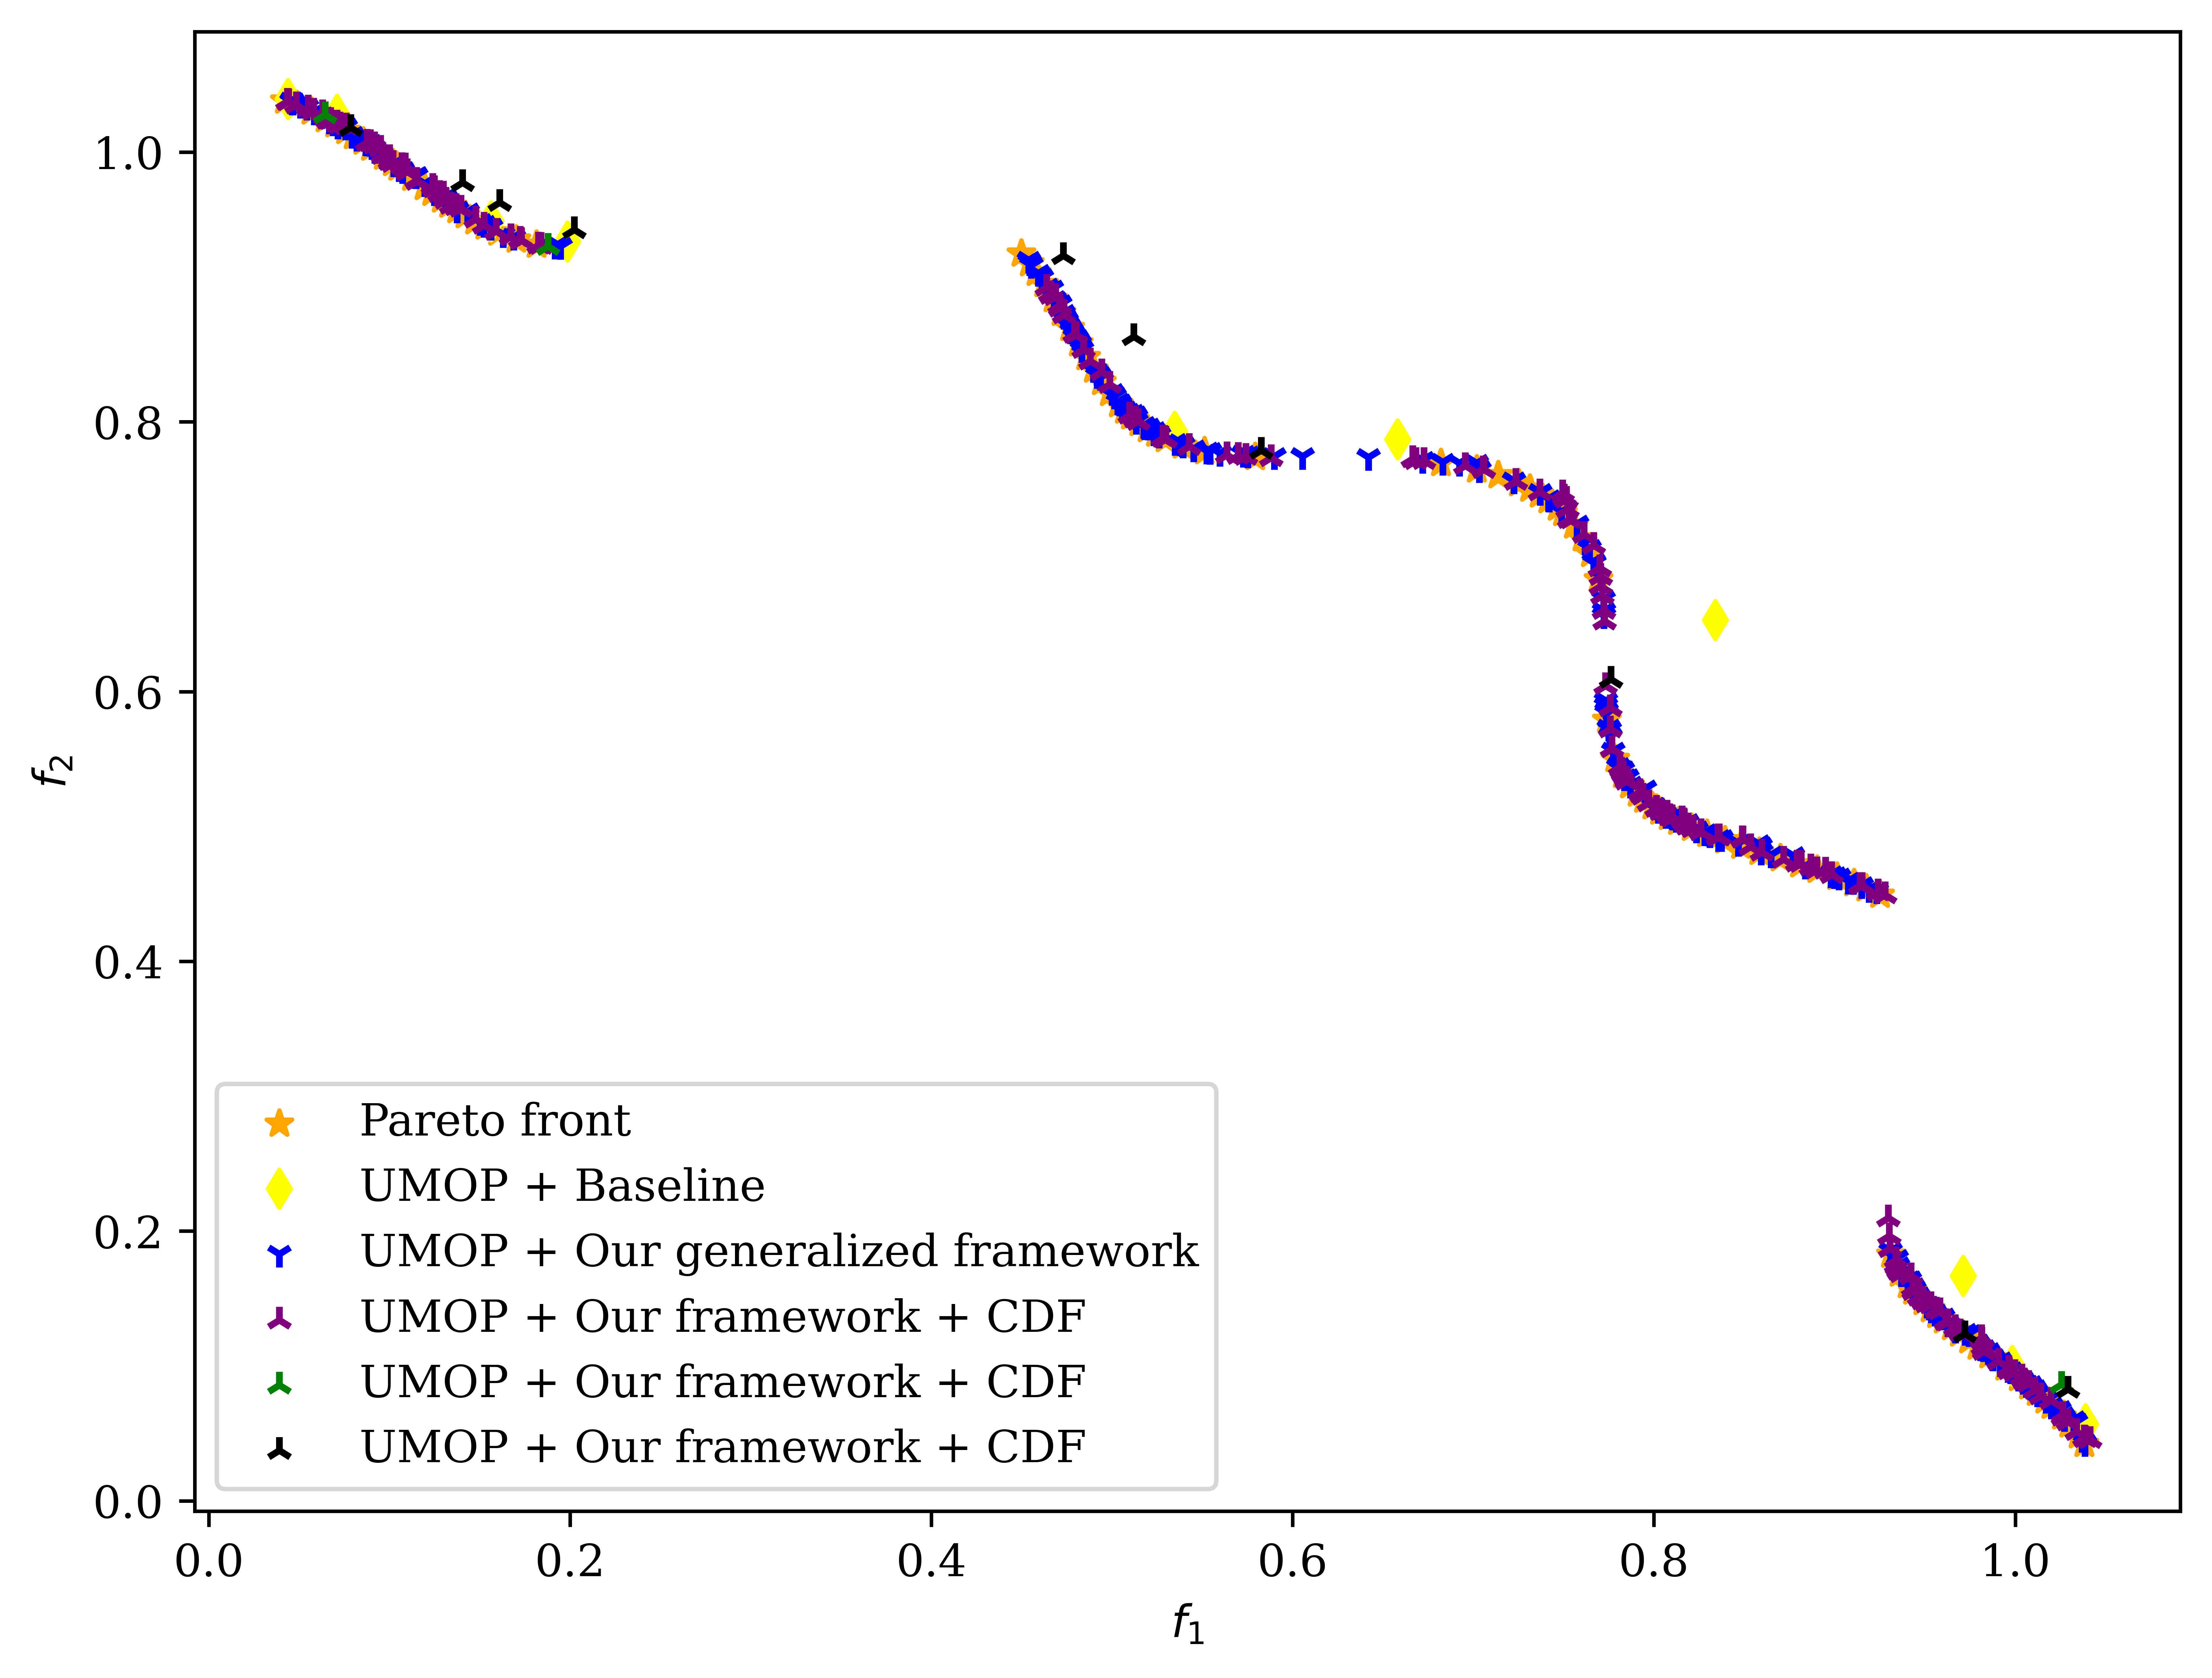

In [16]:
plot = Scatter()
plot.add(pf, marker="*", color="orange", label="Pareto front")
plot.add(results[0].F[results[0].F[:, -1] == 0][:, :-1], marker="d",
         color="yellow", label="UMOP + Baseline")
# plot.add(results[2].F[:, :-1], marker="+",
#  color="green", label="UMOP + Baseline + Our CDP")
plot.add(
    results[1].F[results[1].F[:, -1] == 0][:, :-1], marker="1", color="blue", label="UMOP + Our generalized framework"
)
plot.add(results[2].F[results[2].F[:, -1] == 0][:, :-1], marker="2",
         color="purple", label="UMOP + Our framework + CDF")
plot.add(results[3].F[results[3].F[:, -1] == 0][:, :-2], marker="2",
         color="green", label="UMOP + Our framework + CDF")
plot.add(results[4].F[results[4].F[:, -1] == 0][:, :-2], marker="2",
         color="black", label="UMOP + Our framework + CDF")
plot.show()

In [10]:
results[4].F

array([[1.72917206e+01, 4.42671278e+00, 1.23364619e+01, 5.95360195e+00,
        9.65198797e-01],
       [1.74284314e+01, 4.42685713e+00, 1.23421161e+01, 5.95238971e+00,
        9.56340971e-01],
       [1.57032589e+01, 4.42658385e+00, 1.27881462e+01, 5.95294889e+00,
        9.64996481e-01],
       ...,
       [1.85196771e+01, 4.20755622e+00, 1.29623418e+01, 4.95755735e+00,
        6.16838182e-01],
       [1.79874209e+01, 4.38545697e+00, 1.24977714e+01, 4.95769231e+00,
        7.12448961e-01],
       [3.82506036e+01, 4.03556930e+00, 1.07838202e+01, 9.90609137e-01,
        8.89232472e-03]])